In [13]:
import csv
from diophila import OpenAlex

email = "shx983@mocs.utc.edu"
openalex = OpenAlex(email)

biology_keywords = [
    "scRNA-seq data", "scRNAseq", "bulk RNA data", "transcriptomic data", "transcriptomics",
    "single-cell", "single cell", "biomarker discovery", "biomarker selection",
    "synthetic biological data", "synthetic biology", "bioinformatics", "molecular biology",
    "gene networks", "gene network", "protein folding", "protein structure",
    "single-cell research", "single cell research", "genomics", "genome sequencing",
    "proteomics", "metabolomics", "gene expression data", "gene expression",
    "biological sequences", "biological sequence", "protein structure prediction",
    "biological datasets", "DNA sequences", "RNA sequences", "epigenomics",
    "metagenomics", "transcriptomics", "lipidomics", "glycomics", "nutrigenomics"
]

generative_ai_keywords = [
    "Variational Autoencoder", "VAE", "Generative Adversarial Network", "GAN",
    "Denoising diffusion model", "DDM", "Denoising Diffusion Probabilistic Model", "DDPM",
    "Generative Models", "Generative AI", "Diffusion Models", "Autoencoder", "Generative neural networks"
]

output_file = "openalex_biology_generative_ai.csv"
fieldnames = ["Title", "Journal", "Year", "Abstract", "Cited By Count", "URL", "DOI"]

with open(output_file, mode="w", newline="", encoding="utf-8") as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()

    # Iterate over keywords
    for bio_kw in biology_keywords:
        for ai_kw in generative_ai_keywords:
            search_query = f'"{bio_kw}" "{ai_kw}"'
            filters = {
                "from_publication_date": "2015-01-01"
            }

            works = openalex.get_list_of_works(search=search_query, filters=filters)
            for page in works:
                for work in page['results']:
                    abstract_index = work.get("abstract_inverted_index", {})
                    if abstract_index:
                        position_word_pairs = []
                        for word, positions in abstract_index.items():
                            for pos in positions:
                                position_word_pairs.append((pos, word))
                        position_word_pairs.sort(key=lambda x: x[0])
                        abstract = " ".join(word for _, word in position_word_pairs)
                    else:
                        abstract = "N/A"
                    journal = work.get("host_venue", {}).get("display_name")
                    if not journal:
                        primary_location = work.get("primary_location", {})
                        source = primary_location.get("source") if primary_location else {}
                        if source is None:
                            source = {}
                        journal = source.get("display_name", "N/A")
                    writer.writerow({
                        "Title": work.get("display_name", "N/A"),
                        "Journal": journal,
                        "Year": work.get("publication_year", "N/A"),
                        "Abstract": abstract,
                        "Cited By Count": work.get("cited_by_count", 0),
                        "URL": work.get("id", "N/A"),
                        "DOI": work.get("ids", {}).get("doi", "N/A")
                    })

print(f"Query complete. Results saved to {output_file}")

Query complete. Results saved to openalex_biology_generative_ai.csv


In [14]:
import csv

input_file = "openalex_biology_generative_ai.csv"
output_file = "openalex_biology_generative_ai_filtered.csv"

excluded_substrings = ["bioRxiv", "medRxiv"] # Remove preprints / non-peer reviewed publications
biology_keywords = [k.lower() for k in biology_keywords]
generative_ai_keywords = [k.lower() for k in generative_ai_keywords]

with open(input_file, mode="r", newline="", encoding="utf-8") as infile, \
     open(output_file, mode="w", newline="", encoding="utf-8") as outfile:
    reader = csv.DictReader(infile)
    fieldnames = reader.fieldnames
    writer = csv.DictWriter(outfile, fieldnames=fieldnames)
    writer.writeheader()

    seen_titles = set()
    for row in reader:
        journal = row.get("Journal", "")
        if any(substring in journal for substring in excluded_substrings):
            continue

        # Remove any duplicates
        title = row.get("Title", "")
        if title in seen_titles:
            continue

        # Check to ensure one biology and one generative AI keyword are included in Title OR Abstract
        title_text = row.get("Title", "").lower()
        abstract_text = row.get("Abstract", "").lower()
        combined_text = title_text + " " + abstract_text
        has_biology = any(bio_kw in combined_text for bio_kw in biology_keywords)
        has_ai = any(ai_kw in combined_text for ai_kw in generative_ai_keywords)
        if not (has_biology and has_ai):
            continue

        writer.writerow(row)
        seen_titles.add(title)

print(f"Filtering complete. Results saved to {output_file}")


Filtering complete. Results saved to openalex_biology_generative_ai_filtered.csv


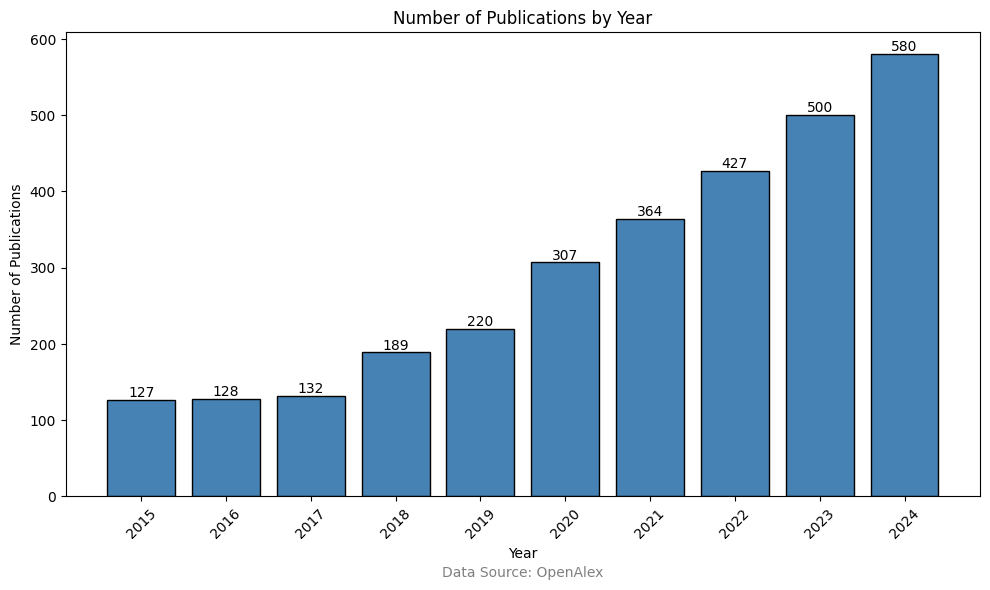

Plot saved as publications_by_year.png


In [2]:
import csv
import matplotlib.pyplot as plt
from collections import Counter

input_file = "openalex_biology_generative_ai_filtered.csv"

years = []

with open(input_file, mode="r", newline="", encoding="utf-8") as infile:
    reader = csv.DictReader(infile)
    for row in reader:
        year = row.get("Year", "")
        if year.isdigit():
            year_int = int(year)
            if 2015 <= year_int <= 2024:  # restrict to 2015–2024
                years.append(year_int)

year_counts = Counter(years)
sorted_years = sorted(year_counts.keys())
counts = [year_counts[y] for y in sorted_years]

plt.figure(figsize=(10, 6))
bars = plt.bar(sorted_years, counts, color="steelblue", edgecolor="black")

for bar, count in zip(bars, counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(count),
             ha='center', va='bottom', fontsize=10)

plt.xlabel("Year")
plt.ylabel("Number of Publications")
plt.title("Number of Publications by Year")
plt.xticks(sorted_years, rotation=45)
plt.text(0.5, -0.15, "Data Source: OpenAlex", fontsize=10, color="gray",
         ha='center', va='top', transform=plt.gca().transAxes)

plt.tight_layout()
output_image = "publications_by_year.png"
plt.savefig(output_image, dpi=300, bbox_inches="tight")
plt.show()

print(f"Plot saved as {output_image}")
